# TP: Measuring raw camera calibration accuracy

### Name: **Nageeta Kumari**

The objective of this TP is to perform a simple camera calibration, and measuring its accuracy.

We will go through the following steps:
- Import a raw image containing a ColorChecker chart
- Extract values from color patches in "linear raw RGB" device colorspace
- Find reference color patch values in CIE-XYZ colorspace
- Find a linear 3x3 color calibration matrix
- Perform color rendering and gamma encoding
- Assess the quality of the calibration
- Compare the raw image to the JPEG image produced by the same sensor

The purpose of the TP is to introduce the basic concept of calibration to reach the fidelity of color rendering and to assess it using a perceptually uniform color space.

Answer the 8 questions below and then export the notebook with the answers using the menu option File->Download .ipynb. **[Then submit your solution here!](https://docs.google.com/forms/d/e/1FAIpQLScZqOU9T5Fuy021Z5-RXmmXFddjrnEyYX0gLsnPJ3EtV4akkg/viewform)**

Install necessary modules:

In [29]:
!pip install colour-science rawpy opencv-python

Import necessary modules:

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import rawpy
import colour
import cv2

In [31]:
# The following lines install the necessary packages in the colab environment
try:
    from google.colab import files
    !pip install -q hdf5storage

    !rm -fr IspPipeline
    !git clone -b main --single-branch --quiet https://github.com/DXOMARK-OCTO/IspPipeline
    !cp -r IspPipeline/* .

except ImportError:
    # %matplotlib notebook
    pass

%matplotlib inline

import fastisp

# Helper function for displaying images
def imshow(im, **kwargs):
  im = im / im.max()
  plt.figure(figsize=(8, 8))
  plt.imshow(im, **kwargs)
  plt.axis('off')
  plt.show()

# Gathering measured data

In this section we will:

- Import a raw image of a ColorChecker chart from a DNG raw file
- Extract linear RGB values measured by the sensor from patches

[DNG](https://helpx.adobe.com/camera-raw/digital-negative.html) (_Digital NeGative_) is a universal file format developped by Adobe, containing the raw data from the sensor as well as some metadata useful to transform the raw data into a viewable image.

The [ColorChecker](https://en.wikipedia.org/wiki/ColorChecker) is a traditional chart for performing color calibration and measurements on image sensors, containing a total of 24 color and gray patches.


Open the DNG image:

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:

filename = "Gretag_6500K_100Lux"
# Gretag_6500K_100lux.jpg
raw = rawpy.imread(rf"./OppoFindX3Pro/ColorChecker/{filename}.dng")

Extract each channel ($R$, $G_1$, $B$, $G_2$) from the raw image data:

In [34]:
imageB = raw.raw_image[::2, ::2]
imageG2 = raw.raw_image[::2, 1::2]
imageR = raw.raw_image[1::2, 1::2]
imageG1 = raw.raw_image[1::2, ::2]

Let's display these channels:

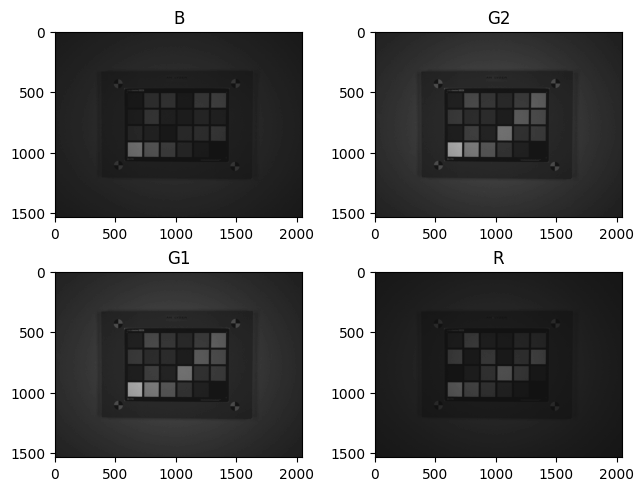

In [35]:
fig, axes = plt.subplots(nrows=2, ncols=2, constrained_layout=True)
axes[0, 0].imshow(imageB, vmin=0, vmax=1024, cmap="gray")
axes[0, 0].set_title("B")
axes[0, 1].imshow(imageG2, vmin=0, vmax=1024, cmap="gray")
axes[0, 1].set_title("G2")
axes[1, 1].imshow(imageR, vmin=0, vmax=1024, cmap="gray")
axes[1, 1].set_title("R")
axes[1, 0].imshow(imageG1, vmin=0, vmax=1024, cmap="gray")
axes[1, 0].set_title("G1")
fig.show()

Find coordinates of patch ROIs from the ColorChecker:

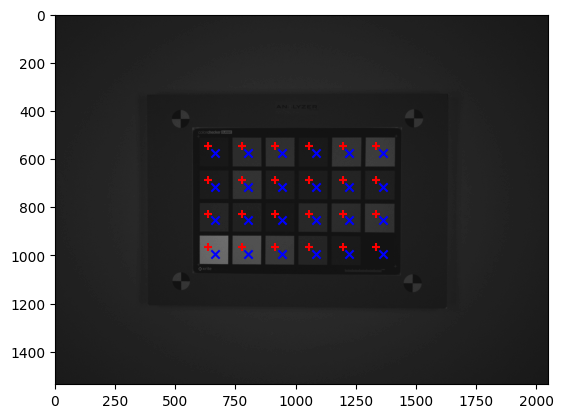

In [36]:
coordinates = ((x0, y0), (x1, y1)) = np.array([
    [580, 490],
    [1420, 1050],
])

rectangles = np.round(np.array([
    [
        [x0 + (0.4+i)/6*(x1-x0), y0 + (0.4+j)/4*(y1-y0)],
        [x0 + (0.6+i)/6*(x1-x0), y0 + (0.6+j)/4*(y1-y0)]
    ] for j in range(4) for i in range(6)
])).astype(int)

plt.imshow(imageB, vmin=0, vmax=1024, cmap="gray")
plt.scatter(*rectangles[:, 0, :].T, marker="+", color="red")
plt.scatter(*rectangles[:, 1, :].T, marker="x", color="blue")
plt.show()

Extract average RGB values from these patches:

In [37]:
patchesR = [np.mean(imageR[py0:py1, px0:px1]) for ((px0, py0), (px1, py1)) in rectangles]
patchesG = [np.mean(imageG1[py0:py1, px0:px1]) for ((px0, py0), (px1, py1)) in rectangles]
patchesB = [np.mean(imageB[py0:py1, px0:px1]) for ((px0, py0), (px1, py1)) in rectangles]
raw_rgb = np.vstack((patchesR, patchesG, patchesB)).T

print("Raw RGB values of gray patches:")
raw_rgb[18:, :]
# they are also affine because they are on black level, the range is between zero and white level (1023)

Raw RGB values of gray patches:


array([[ 320.88647959,  638.99362245,  416.77423469],
       [ 251.09311224,  474.27040816,  319.49362245],
       [ 188.38137755,  331.77423469,  230.78316327],
       [ 127.54464286,  200.44770408,  148.99489796],
       [  93.4744898 ,  128.80994898,  104.88265306],
       [  73.93367347,   86.40816327,   78.18494898]])

Let's explore some of the metadata.

In [38]:
print(f"Bayer pattern: {raw.raw_pattern.tolist()}")
print(f"Black level: {raw.black_level_per_channel}")
print(f"White level: {raw.white_level}")

Bayer pattern: [[2, 3], [1, 0]]
Black level: [64, 64, 64, 64]
White level: 1023


In [39]:
measured_rgb = (raw_rgb - raw.black_level_per_channel[0]) / (raw.white_level - raw.black_level_per_channel[0])

print("Measured RGB values of gray patches:")
measured_rgb[18:, :]

Measured RGB values of gray patches:


array([[ 0.26786911,  0.59957625,  0.36785634],
       [ 0.19509188,  0.42781064,  0.26641671],
       [ 0.12969904,  0.27922235,  0.17391362],
       [ 0.06626136,  0.14228123,  0.08862867],
       [ 0.03073461,  0.06758076,  0.0426305 ],
       [ 0.01035837,  0.02336618,  0.0147914 ]])

> **Question 1**:
>
> What colorspace are RGB values in `raw_rgb` in? What is the expected range of these values?
- The RGB values in raw_rgb represent the sensor's raw RGB values. these values are in the linear raw RGB device colorspace, directly captured by the sensor without any color correction or white balance.
range => 0-1023

> What colorspace are RGB values in `measured_rgb` in? What is the expected range of these values?
- The RGB values in measured_rgb is normalized to account for the sensor's black and white levels, and thier range is between 0 -1, and here 0 corresponds to the absence of light (zero photons captured), and 1 represents the sensor's maximum photon capture(achieving full well capacity)



# Interlude: Measuring the noise response of the sensor

Let's plot the SNR for one green channel of the gray patches, as a function of the grey level in percentage:

In [40]:
stdG = np.array([np.std(imageG1[py0:py1, px0:px1]) for ((px0, py0), (px1, py1)) in rectangles])
SNRG = ( raw_rgb[18:, 1] - raw.black_level_per_channel[0] ) / stdG[18:]

GrayLevels = measured_rgb[18:, 1]

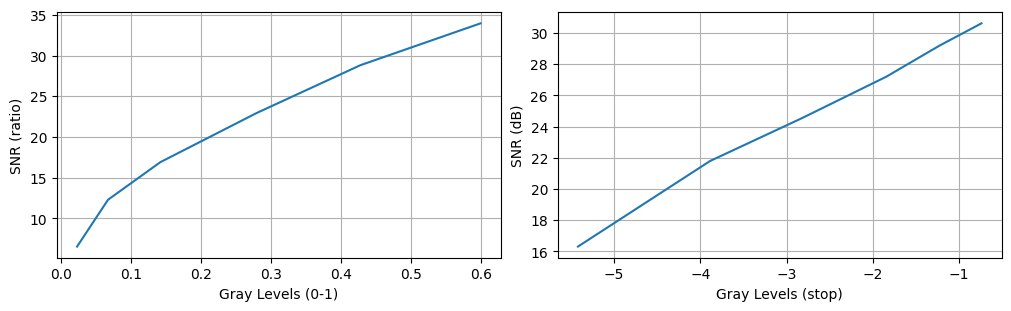

In [41]:
fig, (ax1, ax2) = plt.subplots(ncols=2, constrained_layout=True, figsize=(10, 3))

ax1.plot(GrayLevels, SNRG)
ax1.set_ylabel('SNR (ratio)')
ax1.set_xlabel('Gray Levels (0-1)')
ax1.grid(True)

ax2.plot(np.log2(GrayLevels), 20*np.log10(SNRG))
ax2.set_ylabel('SNR (dB)')
ax2.set_xlabel('Gray Levels (stop)')
ax2.grid(True)

fig.show()


> **Question 2**: Can you give a rough estimate the full well capacity (in photons) of this sensor? How does it compare with other sensors for which we've estimated full well capacities in previous lectures?
>
> It seems that we have a slope of around 3dB per stop around gray levels of 0.125, equivalent to -3 stops relative to saturation.
>
> We assume we're using an ideal sensor, with the following assumptions:
> - The photon to electron conversion is 100% efficient.
> - The sensor is perfectly linear
> - The noise regime is purely photonic at this grey level


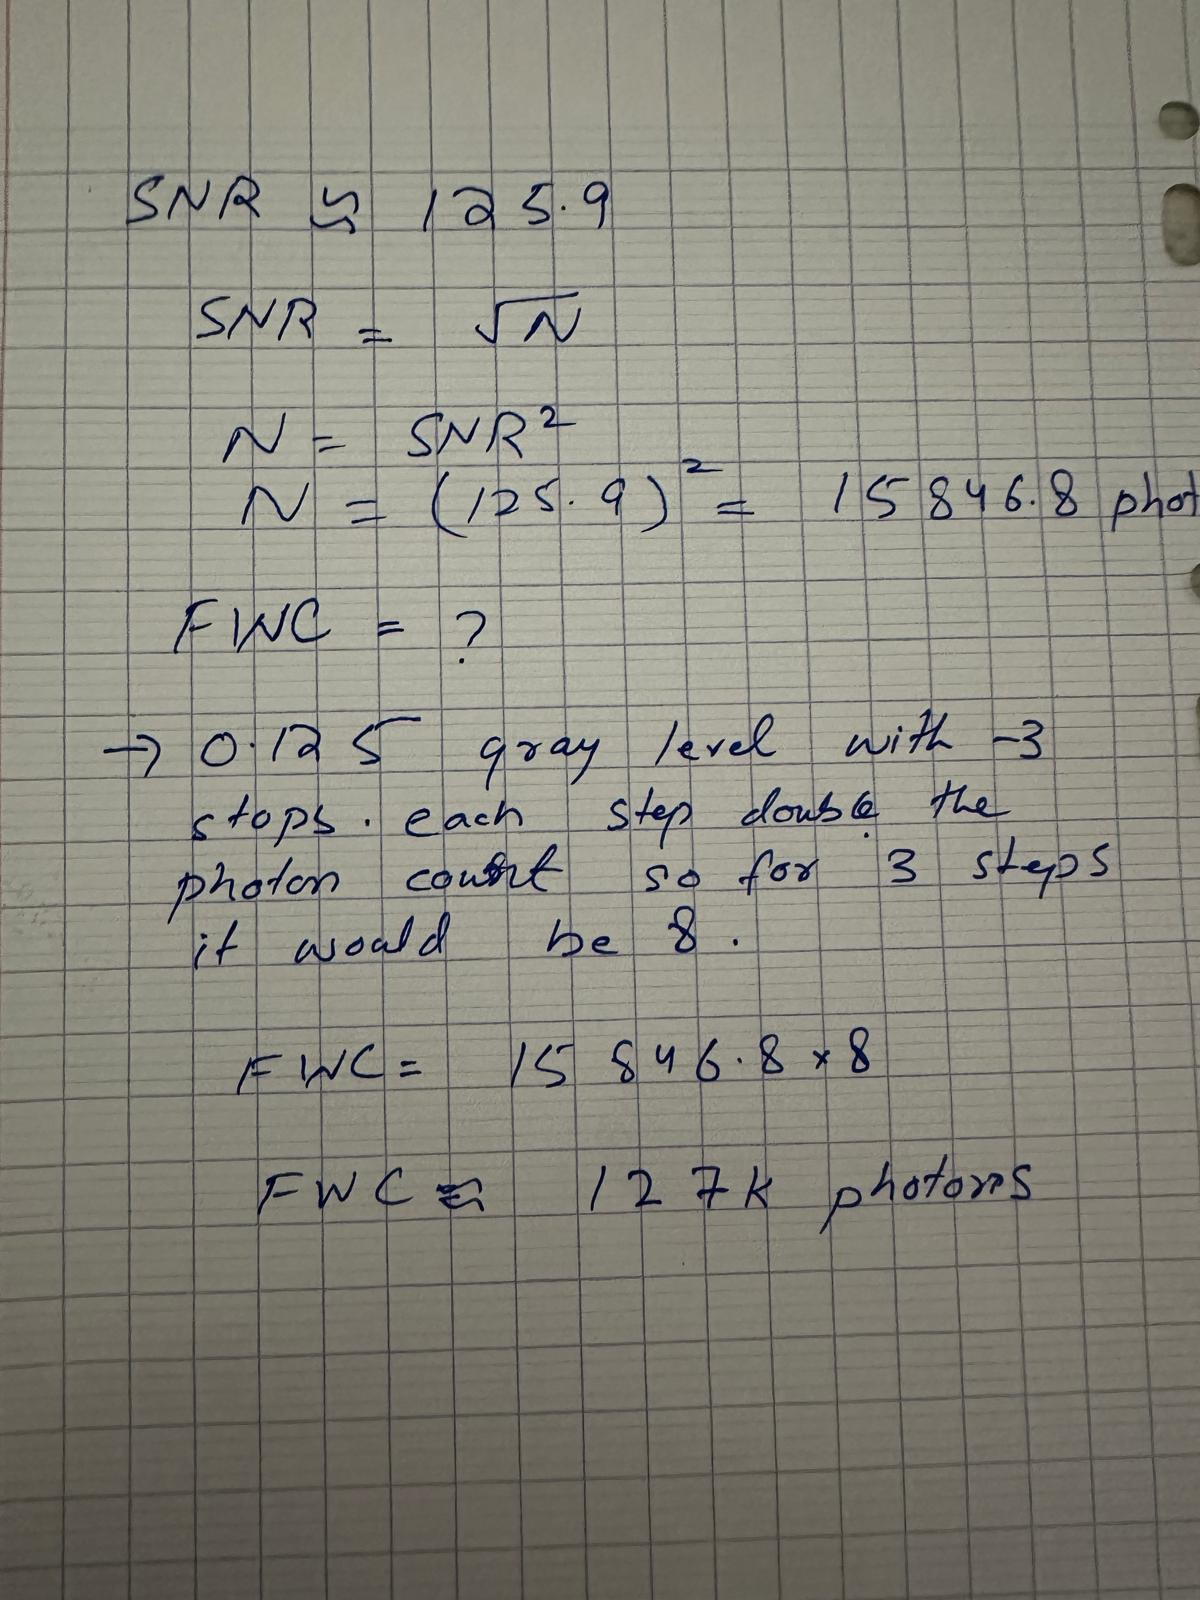

- the FWC for both sensors seems close to each otehr as we get 148 k in previous and arounf 127k now 

# Gathering reference patch data

The [colour-science](https://www.colour-science.org/) library contains reference values in xyY coordinates from various sources, measured under the D50 illuminant.


In [42]:
colour.CCS_COLOURCHECKERS["BabelColor Average"].data

{'dark skin': array([ 0.4325,  0.3788,  0.1034]),
 'light skin': array([ 0.4191,  0.3748,  0.3525]),
 'blue sky': array([ 0.2761,  0.3004,  0.1847]),
 'foliage': array([ 0.37  ,  0.4501,  0.1335]),
 'blue flower': array([ 0.302 ,  0.2877,  0.2324]),
 'bluish green': array([ 0.2856,  0.391 ,  0.4174]),
 'orange': array([ 0.5291,  0.4075,  0.3117]),
 'purplish blue': array([ 0.2339,  0.2155,  0.114 ]),
 'moderate red': array([ 0.5008,  0.3293,  0.1979]),
 'purple': array([ 0.3326,  0.2556,  0.0644]),
 'yellow green': array([ 0.3989,  0.4998,  0.4435]),
 'orange yellow': array([ 0.4962,  0.4428,  0.4358]),
 'blue': array([ 0.204 ,  0.1696,  0.0579]),
 'green': array([ 0.327 ,  0.5033,  0.2307]),
 'red': array([ 0.5709,  0.3298,  0.1268]),
 'yellow': array([ 0.4694,  0.4732,  0.6081]),
 'magenta': array([ 0.4177,  0.2704,  0.2007]),
 'cyan': array([ 0.2151,  0.3037,  0.1903]),
 'white 9.5 (.05 D)': array([ 0.3488,  0.3628,  0.9129]),
 'neutral 8 (.23 D)': array([ 0.3451,  0.3596,  0.5885])

In [43]:
# Chromaticity coordinates in CIE-xyY space
cc_xyY = np.array([v for v in colour.CCS_COLOURCHECKERS["BabelColor Average"].data.values()])

# Chromaticity in CIE-XYZ space
cc_XYZ = colour.xyY_to_XYZ(cc_xyY)

print(cc_XYZ)


[[ 0.11805834  0.1034      0.05150892]
 [ 0.39416422  0.3525      0.19383738]
 [ 0.16975922  0.1847      0.26038765]
 [ 0.10974228  0.1335      0.05335848]
 [ 0.24395134  0.2324      0.33143455]
 [ 0.30488348  0.4174      0.3452357 ]
 [ 0.40471281  0.3117      0.04849517]
 [ 0.12373364  0.114       0.29126868]
 [ 0.30096666  0.1979      0.1021051 ]
 [ 0.08380063  0.0644      0.10375556]
 [ 0.35396589  0.4435      0.08988906]
 [ 0.48835583  0.4358      0.06003568]
 [ 0.06964387  0.0579      0.21384764]
 [ 0.14988854  0.2307      0.07778619]
 [ 0.21949703  0.1268      0.03817841]
 [ 0.60321669  0.6081      0.07376361]
 [ 0.31003103  0.2007      0.2315027 ]
 [ 0.13478278  0.1903      0.30152242]
 [ 0.87767233  0.9129      0.72569008]
 [ 0.56477016  0.5885      0.48327044]
 [ 0.34507994  0.3595      0.29681281]
 [ 0.18315564  0.1912      0.15838328]
 [ 0.08547928  0.0893      0.07494108]
 [ 0.030869    0.032       0.02689257]]


> **Question 3:** What is the range of these values? Are white and black patches of the ColorChecker exactly white and black?

Answer:
- Range y(white) is luminous and it's range is from 0-1
while x and z are not between 0 and 1, but they are normalized here, and x and z(blue) depends on what type of light we are using. so x and z can vary according to the speturm of light.

- the white and black patches on the ColorChecker are not exactly pure white and pure black. The white patch does not reach a full luminance of 1, and the black patch does not reach absolute zero.this can be due to reflective properties of the materials or may be due to how much light is observed(envorimental effect)


# Finding the calibration matrix

Thanks to these XYZ references, we will find the best matrix that transform the raw data (proportionnal to luminance in the scene) to XYZ, through least mean square minimization.

In [44]:
# Build a linear system
A = []
b = []
for measured_rgb_patch, reference_xyz_patch in zip(measured_rgb, cc_XYZ):
  A.append(measured_rgb_patch.tolist() + [0, 0, 0, 0, 0, 0])
  A.append([0, 0, 0] + measured_rgb_patch.tolist() + [0, 0, 0])
  A.append([0, 0, 0, 0, 0, 0] + measured_rgb_patch.tolist())
  b.extend(reference_xyz_patch)

A = np.array(A)
b = np.array(b)

# ... and solve it!
Mvalues, resid, _, _ = np.linalg.lstsq(A, b, rcond=None)
M = Mvalues.reshape((3, 3))

print(f"Residual:{resid}")
print(f"Calibration Matrix:\n{M}")

Residual:[ 0.04347991]
Calibration Matrix:
[[ 1.6272603   0.5343472   0.1071037 ]
 [ 0.39422292  1.43767903 -0.33939293]
 [-0.09769724 -0.38575556  2.55114294]]


The [colour-science](https://www.colour-science.org/) library provides useful tools to visualize color patches! Let's look at the results.

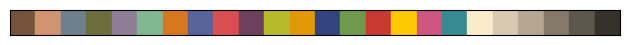

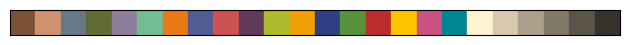

In [45]:
rgb = colour.XYZ_to_sRGB((M @ measured_rgb.T).T)
swatches = [colour.plotting.common.ColourSwatch(x) for x in rgb]
colour.plotting.plot_multi_colour_swatches(swatches, coloums=6)
plt.show()

rgb = colour.XYZ_to_sRGB(cc_XYZ)
swatches = [colour.plotting.common.ColourSwatch(x) for x in rgb]
colour.plotting.plot_multi_colour_swatches(swatches, coloums=6)
plt.show()

> **Question 4:** What is the goal of the `colour.XYZ_to_sRGB` function? Why are the gray patches slightly yellow?

-  colour.XYZ_to_sRGB converts the colors space to RGB space, because sRGB is the standard colorspace for digital displays so this conversion allows to visualize color patches on screens as XYZ values represent a color model that is not directly interpretable for display purposes.

- yellow because, the BabelColor Average have slight deviations from a perfect neutral gray, which can introduce a yellowish bias.


# Finding the calibration matrix under a different illuminant

Let's generate reference values under another illuminant: [D65](https://en.wikipedia.org/wiki/Illuminant_D65) in order to display the resulting image.

While we could go in the lab and measure patches with a spectrometer under that illuminant, it is possible to find an estimate of a XYZ color under an illuminant given the XYZ color coordinates under another illuminant, using "chromatic adaptation" models. The [Bradford adaptation](http://www.brucelindbloom.com/index.html?Eqn_ChromAdapt.html) is one of the chromatic adaptation models that we propose to use here.

In [46]:
cc_xyY_d50 = np.array([v for v in colour.CCS_COLOURCHECKERS["BabelColor Average"].data.values()])
XYZ_wr_d65 = colour.xy_to_XYZ(colour.CCS_ILLUMINANTS["cie_2_1931"]["D65"])
XYZ_w_d50 = colour.xy_to_XYZ(colour.CCS_ILLUMINANTS["cie_2_1931"]["D50"])
m_d50_to_d65 = colour.adaptation.matrix_chromatic_adaptation_VonKries(XYZ_w_d50, XYZ_wr_d65, "Bradford")
cc_XYZ_d50 = colour.xyY_to_XYZ(cc_xyY_d50)
cc_XYZ_d65 = (m_d50_to_d65 @ cc_XYZ_d50.T).T

print(cc_XYZ_d65)

[[ 0.11367164  0.10216807  0.067859  ]
 [ 0.38073324  0.34891967  0.25549944]
 [ 0.17440606  0.18720906  0.34471351]
 [ 0.1051476   0.13284377  0.0695999 ]
 [ 0.24868724  0.23477596  0.43916727]
 [ 0.30350611  0.42018688  0.45448426]
 [ 0.38256031  0.30435439  0.06310772]
 [ 0.13401642  0.1177579   0.38667971]
 [ 0.28945355  0.19348819  0.13548479]
 [ 0.08514523  0.06484947  0.13774409]
 [ 0.33364715  0.43978245  0.11484894]
 [ 0.46034252  0.42756472  0.07694581]
 [ 0.0787333   0.06100262  0.28416582]
 [ 0.14280639  0.23039038  0.10059871]
 [ 0.20920983  0.12264368  0.05089378]
 [ 0.56697758  0.59861721  0.09308991]
 [ 0.30623523  0.19878174  0.30768514]
 [ 0.14345981  0.19472284  0.39889227]
 [ 0.86341261  0.91239506  0.95751959]
 [ 0.55660076  0.58852863  0.63781236]
 [ 0.34018697  0.3595489   0.39174647]
 [ 0.18060313  0.19124766  0.20904204]
 [ 0.0843512   0.08934444  0.09892032]
 [ 0.03045657  0.03200997  0.03550083]]


In [47]:
# Build a linear system
A = []
b = []
for measured_rgb_patch, reference_xyz_patch in zip(measured_rgb, cc_XYZ_d65):
  A.append(measured_rgb_patch.tolist() + [0, 0, 0, 0, 0, 0])
  A.append([0, 0, 0] + measured_rgb_patch.tolist() + [0, 0, 0])
  A.append([0, 0, 0, 0, 0, 0] + measured_rgb_patch.tolist())
  b.extend(reference_xyz_patch)

A = np.array(A)
b = np.array(b)

# ... and solve it!
Mvalues, resid, _, _ = np.linalg.lstsq(A, b, rcond=None)
M_D65 = Mvalues.reshape((3, 3))

print(f"Residual:{resid}")
print(f"Calibration Matrix for the D65 illuminant:\n{M_D65}")

Residual:[ 0.04548586]
Calibration Matrix for the D65 illuminant:
[[ 1.53951778  0.45294378  0.27155756]
 [ 0.34994274  1.42877307 -0.29214407]
 [-0.11801956 -0.53609951  3.40223267]]


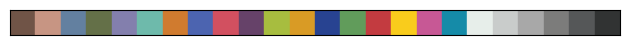

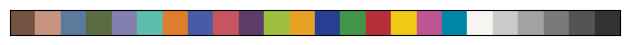

In [48]:
rgb = colour.XYZ_to_sRGB((M_D65 @ measured_rgb.T).T)
swatches = [colour.plotting.common.ColourSwatch(x) for x in rgb]
colour.plotting.plot_multi_colour_swatches(swatches, coloums=6)
plt.show()

rgb = colour.XYZ_to_sRGB(cc_XYZ_d65)
swatches = [colour.plotting.common.ColourSwatch(x) for x in rgb]
colour.plotting.plot_multi_colour_swatches(swatches, coloums=6)
plt.show()

> **Question 5:** In CIE-XYZ, what is the colour of "gray"?
what makes a surface gray? what physical properties makes it gray?

- In the CIE-XYZ colorspace, a gray color has the property that its  coordinates (x and y) remain constant regardless of luminance (Y).
As X, Y, and Z values are balanced there is only luminous.

- A surface appears gray when it reflects light equally across the visible spectrum without emphasizing any particular wavelength.(a surface which its properties are independent from wavelength), this balanced reflectance creates a neutral color perceived as gray, independent of any specific hue.


# Applying Calibration

Let's apply the calibration matrix to the image, and observe the results.

(1536, 2048, 3)


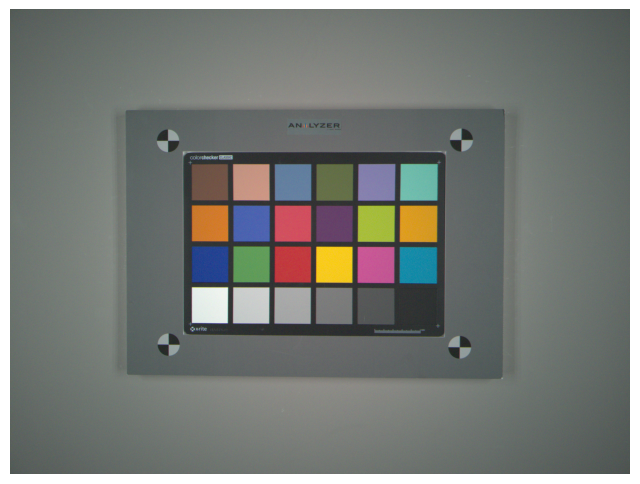

In [49]:
img_raw = (np.dstack([imageR, imageG1, imageB]).astype(np.float32) - raw.black_level_per_channel[0]) / (raw.white_level - raw.black_level_per_channel[0])
img_rgb = np.clip(colour.XYZ_to_sRGB((M_D65 @ img_raw.reshape(-1, 3).T).T.reshape(img_raw.shape)), 0, 1)
print(img_rgb.shape)
img_bgr = cv2.cvtColor(np.array(img_rgb*255,'uint8'), cv2.COLOR_RGB2BGR)
cv2.imwrite("img_rgb.jpg",img_bgr)

imshow(img_rgb)
plt.show()

> **Question 6:** What does the above code do?

- code applies the calibration matrix (M_D65) to the raw image data, converting it from linear raw RGB (sensor values) to the sRGB color space.
- matrix M_D65 adjusts the raw RGB data to align with the color characteristics under the D65 illuminant. This step includes white balance (from the calibration matrix)
-colour.XYZ_to_sRGB function handles conversion to sRGB and gamma encoding (since sRGB applies a gamma curve)


> Where are all the steps from the processing pipeline introduced in the last TP? Where are the demosaicing, white balance, color rendering and gamma steps?

- demosaicing is not explicitly shown here, the code assumes we already have separate RGB channels
- white balance is applied through the calibration matrix (M_D65)
- color rendering and gamma are done in the XYZ_to_sRGB conversion

# Comparing to other renderings

Let's load the JPEG files provided by the camera:

In [50]:
path = r"/content/OppoFindX3Pro/ColorChecker/Gretag_6500K_100lux.jpg"
img_jpg = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)[::2, ::2, :]

Let's generate the image from the previous TP:

In [51]:
cm = raw.color_matrix[0:3,0:3]
print(f"Color Matrix: {cm}")
wb = np.array(raw.camera_whitebalance)
print(f"White Balance: {wb}")

img_isp = fastisp.isp(raw.raw_image, raw.raw_pattern, raw.black_level_per_channel[0], 1.8, wb[:3], cm, raw.white_level)
img_isp = img_isp[::2, ::2, :]

Color Matrix: [[ 1.7879809  -0.80493003  0.01694908]
 [-0.1830969   1.2751694  -0.09207252]
 [-0.0547976  -0.6531928   1.7079904 ]]
White Balance: [ 1.98449612  1.          1.59006214  0.        ]


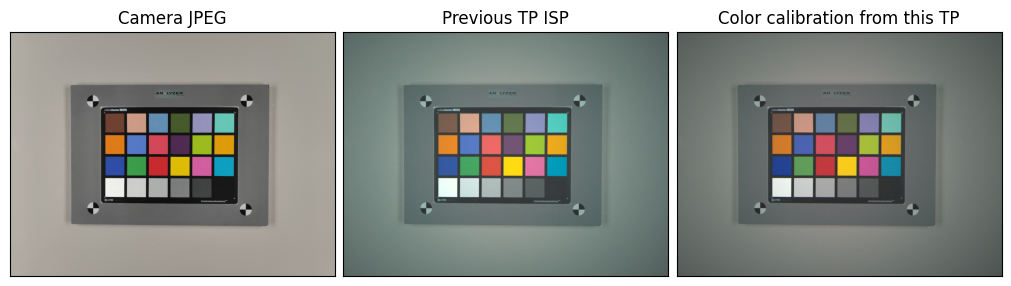

In [52]:
fig, axes = plt.subplots(ncols=3, constrained_layout=True, figsize=(10, 3))

axes[0].imshow(img_jpg)
axes[0].set_title("Camera JPEG")
axes[1].imshow(img_isp)
axes[1].set_title("Previous TP ISP")
axes[2].imshow(img_rgb)
axes[2].set_title("Color calibration from this TP")

for ax in axes:
  ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

plt.show()

In [53]:
# extract rgb values from all patches
patchesR = [np.mean(img_jpg[py0:py1, px0:px1,0]/255) for ((px0, py0), (px1, py1)) in rectangles]
patchesG = [np.mean(img_jpg[py0:py1, px0:px1,1]/255) for ((px0, py0), (px1, py1)) in rectangles]
patchesB = [np.mean(img_jpg[py0:py1, px0:px1,2]/255) for ((px0, py0), (px1, py1)) in rectangles]
patches_jpg = np.vstack((patchesR, patchesG, patchesB)).T

patchesR = [np.mean(img_rgb[py0:py1, px0:px1,0]) for ((px0, py0), (px1, py1)) in rectangles]
patchesG = [np.mean(img_rgb[py0:py1, px0:px1,1]) for ((px0, py0), (px1, py1)) in rectangles]
patchesB = [np.mean(img_rgb[py0:py1, px0:px1,2]) for ((px0, py0), (px1, py1)) in rectangles]
patches_rgb = np.vstack((patchesR, patchesG, patchesB)).T

patchesR = [np.mean(img_isp[py0:py1, px0:px1,0]) for ((px0, py0), (px1, py1)) in rectangles]
patchesG = [np.mean(img_isp[py0:py1, px0:px1,1]) for ((px0, py0), (px1, py1)) in rectangles]
patchesB = [np.mean(img_isp[py0:py1, px0:px1,2]) for ((px0, py0), (px1, py1)) in rectangles]
patches_isp = np.vstack((patchesR, patchesG, patchesB)).T

print("Gray patch #21 (JPEG image):")
print(patches_jpg[21])
print("Gray patch #21 (RGB calibration from this TP):")
print(patches_rgb[21])
print("Gray patch #21 (ISP from previous TP):")
print(patches_isp[21])

Gray patch #21 (JPEG image):
[ 0.48740496  0.4952481   0.49132653]
Gray patch #21 (RGB calibration from this TP):
[ 0.48417472  0.48464614  0.48302548]
Gray patch #21 (ISP from previous TP):
[ 0.50426805  0.54216305  0.53375786]


We will use the [CIELAB](https://en.wikipedia.org/wiki/CIELAB_color_space) color space to quantify the differences between the images:

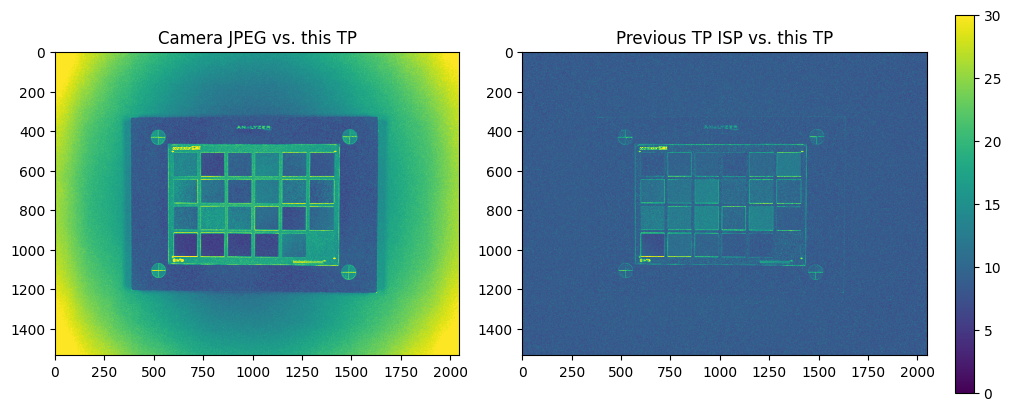

In [54]:
# @title
fig, (ax_jpg, ax_isp) = plt.subplots(ncols=2, constrained_layout=True, figsize=(10, 4))

deltalab_jpg = colour.XYZ_to_Lab(colour.sRGB_to_XYZ(img_jpg / 255.0)) - colour.XYZ_to_Lab(colour.sRGB_to_XYZ(img_rgb))
deltae_jpg = np.linalg.norm(deltalab_jpg, axis=-1)
im = ax_jpg.imshow(deltae_jpg, vmin=0, vmax=30)
ax_jpg.set_title("Camera JPEG vs. this TP")

deltalab_isp = colour.XYZ_to_Lab(colour.sRGB_to_XYZ(img_isp)) - colour.XYZ_to_Lab(colour.sRGB_to_XYZ(img_rgb))
deltae_isp = np.linalg.norm(deltalab_isp, axis=-1)
im = ax_isp.imshow(deltae_isp, vmin=0, vmax=30)
ax_isp.set_title("Previous TP ISP vs. this TP")

fig.colorbar(im, ax=ax_isp)

plt.show()

Differences on each patch:

In [55]:
patches_lab_jpg = colour.XYZ_to_Lab(colour.sRGB_to_XYZ(patches_jpg))
patches_lab_rgb = colour.XYZ_to_Lab(colour.sRGB_to_XYZ(patches_rgb))
patches_lab_isp = colour.XYZ_to_Lab(colour.sRGB_to_XYZ(patches_isp))

patches_deltae_rgb = np.linalg.norm(patches_lab_jpg - patches_lab_rgb, axis=-1)
patches_deltae_isp = np.linalg.norm(patches_lab_isp - patches_lab_rgb, axis=-1)

print("DeltaE between camera JPEG and this TP:")
print(patches_deltae_rgb)
print("DeltaE between ISP from previous TP and this TP:")
print(patches_deltae_isp)

DeltaE between camera JPEG and this TP:
[ 11.53478737   3.20889553   6.67561199  10.56731881   8.15732795
   5.83507053  10.50611535   9.17716482   4.02512582   9.23329065
   8.82152764   5.94590173   6.97358316  15.08116168   9.6690662
   8.38707265   3.74166451   8.47525606   2.53364237   1.55976297
   2.68578184   1.21425909   8.36922135  12.64489249]
DeltaE between ISP from previous TP and this TP:
[  5.0201202    7.45150174   7.78085088   5.22713831   8.50319887
  11.10917462   9.18630967  10.00753395  12.13893401   8.22676836
  10.13646147   7.95033845  11.34364986  10.94007055  12.70364682
   8.8981947   12.23680742   6.8299299    5.95536742   9.28049562
   7.8445635    6.24193334   5.19915331   4.52376862]


> **Question 7:** How do the 3 tested RGB images comapre?
>
> Is the difference between the calibrated image and the isp image perceptually lower than the difference between the calibrated image and the camera image?

> What kind of calibration is obviously missing in both our TPs compared to the camera JPEG?

-  camera JPEG image has a more processed look with higher contrast and corner corrections.
- previous TP image lacks some of the refined processing present in the JPEG
-  calibrated image from this TP is accurate in color representation but lack some visual enhancements like contrast adjustments and corner corrections that we can see in camera image

- difference between the calibrated image and the ISP image is perceptually lower compared to the difference between the calibrated image and the camera JPEG. this may be because ISP processing pipeline is closer to our calibrated output in terms of raw color accuracy but lacks the additional adjustments the camera JPEG applies.


# Going further

> **Question 8:**
>
> In this simple example, we took a lot of shortcuts.
>
> * While we showed the impact of changing the _display_ illuminant, we only ran this example with an image _measured_ under a single illuminant. What happens if you use another illuminant, and why?
> * What happens on another device? Will the calibration stay the same? Why, or why not?
> * Try to use the calibration on a more realistic image, such as a portrait. What could you improve?
> * What color is rendered best, and what color is rendered worst? How could you improve the calibration protocol we used here?
> * The camera-generated JPEG can be very different. What additional calibrations do you think they included, and what would their effect be on the color calibration we performed here?



### While we showed the impact of changing the display illuminant, we only ran this example with an image measured under a single illuminant. What happens if you use another illuminant, and why?

- the calibration matrix was optimized for D65 illumination, meaning it assumes the colors in the scene are illuminated by a D65 (standard daylight) light source, and the image Gretag_2800K_10Lux is not taken in day light, the colors seems warmer in this one as compare to the above one that's why after applying the D65 the colors in image become more warmer and shits towards yellow/brown shade

- so it happens because because the image was captured under a warmer light source than D65, that's whys the it shifts towards yellowish tone





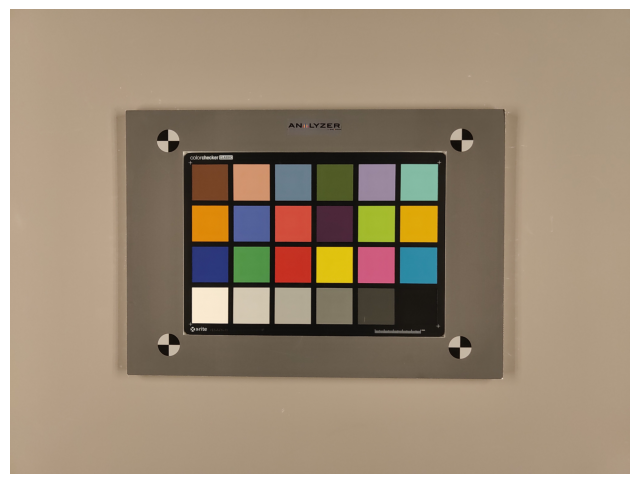

In [60]:
filename = "Gretag_2800K_10Lux"
raw = rawpy.imread(rf"./OppoFindX3Pro/ColorChecker/{filename}.dng")
imageB = raw.raw_image[::2, ::2]
imageG2 = raw.raw_image[::2, 1::2]
imageR = raw.raw_image[1::2, 1::2]
imageG1 = raw.raw_image[1::2, ::2]

path = r"/content/OppoFindX3Pro/ColorChecker/Gretag_2800K_10Lux.jpg"
img_jpg = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)[::2, ::2, :]
imshow(img_jpg)
plt.show()

(1536, 2048, 3)


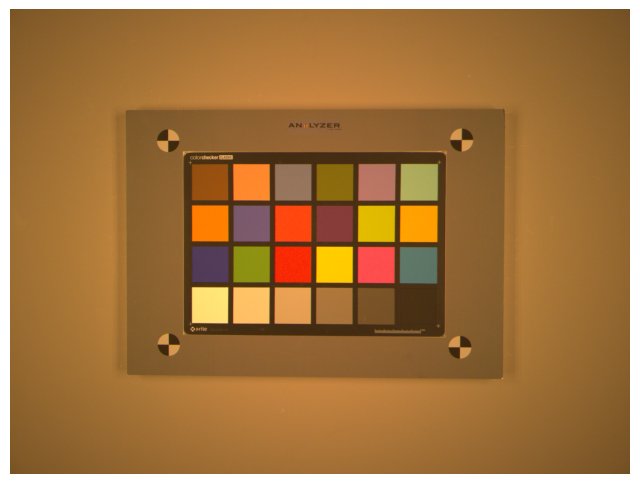

In [61]:
img_raw = (np.dstack([imageR, imageG1, imageB]).astype(np.float32) - raw.black_level_per_channel[0]) / (raw.white_level - raw.black_level_per_channel[0])
img_rgb = np.clip(colour.XYZ_to_sRGB((M_D65 @ img_raw.reshape(-1, 3).T).T.reshape(img_raw.shape)), 0, 1)
print(img_rgb.shape)
img_bgr = cv2.cvtColor(np.array(img_rgb*255,'uint8'), cv2.COLOR_RGB2BGR)
cv2.imwrite("img_rgb.jpg",img_bgr)

imshow(img_rgb)
plt.show()


### What happens on another device? Will the calibration stay the same? Why, or why not?
- i used ISO300.dng caputed from Pixel3a and the original image seems to taken in standard day light but after appliying the transformation it seems that it has somehow male changes in the saturation(incraese/decrease) in image
- the reason can be becuase every device have different sensors and cameras that perceives colors and light in different ways, that's why this callibration does not provide the reuslts as we got in our above experimnets
- calibration matrices rely on both the illuminant and the device's unique characteristics. that's why, even under same lighting conditions, each device's distinct sensor characteristics require specific calibration to achieve accurate color rendering

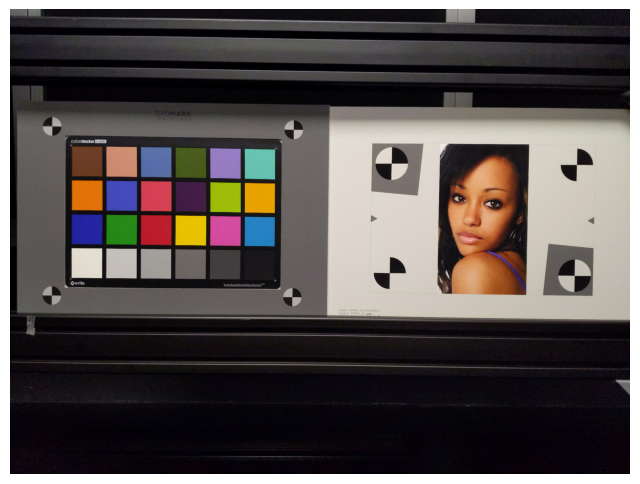

In [62]:
# ISO300.dng
filename = "ISO300"
raw = rawpy.imread(rf"./Pixel3a/{filename}.dng")
imageB = raw.raw_image[::2, ::2]
imageG2 = raw.raw_image[::2, 1::2]
imageR = raw.raw_image[1::2, 1::2]
imageG1 = raw.raw_image[1::2, ::2]

path = r"/content/Pixel3a/ISO300.jpg"
img_jpg = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)[::2, ::2, :]
imshow(img_jpg)
plt.show()

(1512, 2016, 3)


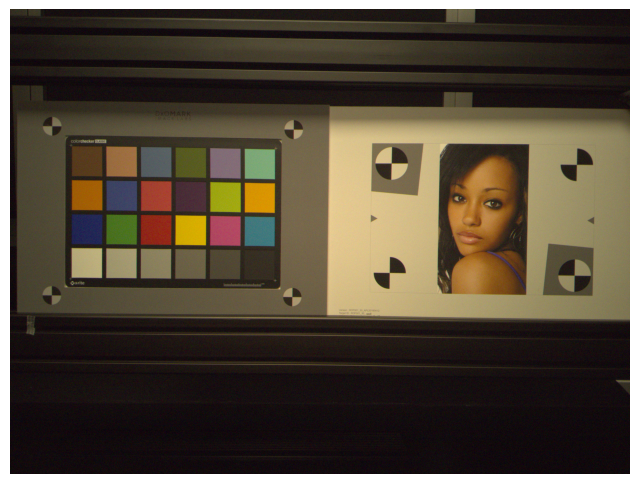

In [63]:
img_raw = (np.dstack([imageR, imageG1, imageB]).astype(np.float32) - raw.black_level_per_channel[0]) / (raw.white_level - raw.black_level_per_channel[0])
img_rgb = np.clip(colour.XYZ_to_sRGB((M_D65 @ img_raw.reshape(-1, 3).T).T.reshape(img_raw.shape)), 0, 1)
print(img_rgb.shape)
img_bgr = cv2.cvtColor(np.array(img_rgb*255,'uint8'), cv2.COLOR_RGB2BGR)
cv2.imwrite("img_rgb.jpg",img_bgr)

imshow(img_rgb)
plt.show()

#### Try to use the calibration on a more realistic image, such as a portrait. What could you improve?
- The callibrated image when comparing with the original one, it seems to shift colors a bit, but it reduces the contract and make the image smooth and a bit brighter than the orginal one.
- In original image the face of the women is sharper and give more details about face while in callibrated image the face of women smooths alot and we lost the details
- this happnes because, the calibration matrix is optimized for colors in the colorchecker under specific lighting conditions. It doesn't adapt dynamically to different areas of the image or lighting variations, which are present in a portrait scene like on face.

- for improving results, either we can generate another callibration matrix that is better for relatistic portiat images, or may be try some nonlinear models that caputers relaistic images well

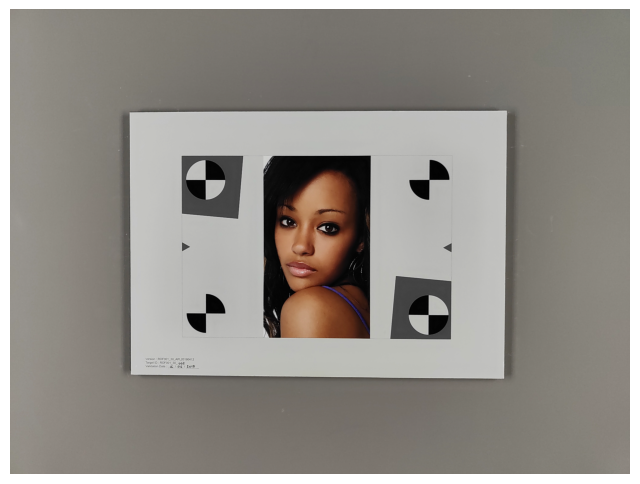

In [68]:
filename = "Portrait_6500K_100Lux"
raw = rawpy.imread(rf"./OppoFindX3Pro/Portrait/{filename}.dng")
imageB = raw.raw_image[::2, ::2]
imageG2 = raw.raw_image[::2, 1::2]
imageR = raw.raw_image[1::2, 1::2]
imageG1 = raw.raw_image[1::2, ::2]

path = r"/content/OppoFindX3Pro/Portrait/Portrait_6500K_100Lux.jpg"
img_jpg = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)[::2, ::2, :]
imshow(img_jpg)
plt.show()

(1536, 2048, 3)


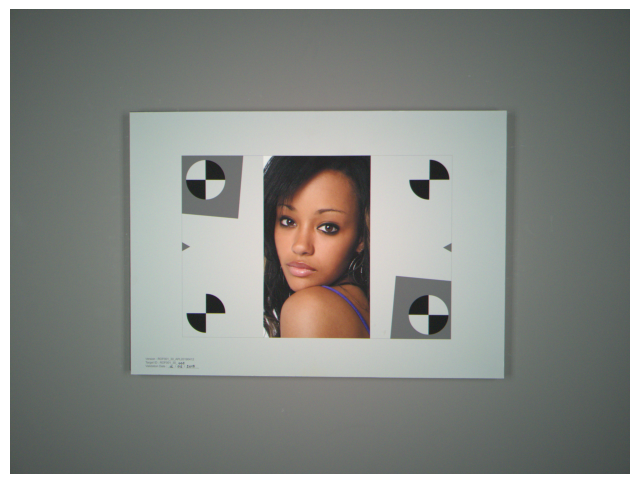

In [69]:
img_raw = (np.dstack([imageR, imageG1, imageB]).astype(np.float32) - raw.black_level_per_channel[0]) / (raw.white_level - raw.black_level_per_channel[0])
img_rgb = np.clip(colour.XYZ_to_sRGB((M_D65 @ img_raw.reshape(-1, 3).T).T.reshape(img_raw.shape)), 0, 1)
print(img_rgb.shape)
img_bgr = cv2.cvtColor(np.array(img_rgb*255,'uint8'), cv2.COLOR_RGB2BGR)
cv2.imwrite("img_rgb.jpg",img_bgr)

imshow(img_rgb)
plt.show()

#### What color is rendered best, and what color is rendered worst? How could you improve the calibration protocol we used here?
- colors that are variations of grey or natural gray seems to be rendered very well and primary colors RGB aslso seems to be renedered better than other
- i feel like yellow and white seems to rendered badly in this example "Gretag_2800K_10Lux", while natural colors of skin from above portait is also seems badly rendered
- For Improvment
    -  a nonlinear model can perform better, to handle the complexity of colors better, especially for hues like skin tones and other tertiary colors that do not align perfectly.
    - try different callibration as per the luminant under which image is captured, or may be adaptive color calibration based on context of iamge will work  better then just a single illunimnat we used above

#### The camera-generated JPEG can be very different. What additional calibrations do you think they included, and what would their effect be on the color calibration we performed here?
- the camera generated image(JPEG) may looks differnt because the camera apply some callibration so that visually image looks good, and those can be white balance to adjust , gamma correction, noise reduction and sharpening, saturation and contrast based callibration to look image visually more appealing.

- it's possible that these modifications disrupt the relationship between measured RGB values and reference XYZ values that our above calibration matrix M_D65 aims to preserve.